In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.sparse as sparse #for numpy.array - pd.dataframe column conversion
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import os, sys, math, json
import warnings
warnings.filterwarnings('ignore')
print('Necessary modules loaded.')

2024-07-11 12:36:56.874350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Necessary modules loaded.


In [2]:
os.makedirs('plots', exist_ok=True)
print('Folder ready.')

Folder ready.


## Preparing the dataframe
### Reading the input files

In [3]:
def csv_to_df(samplename_, nrows_):
    df = pd.read_csv(f'FlattenedCSVFiles/df_{samplename_}.csv', nrows=nrows_)
    df['sample'] = samplename_
    df = df[df['phoPt']>10] #Global pT cut
    return df

df_gjet = pd.concat([
    csv_to_df('GJet_PT-10to40', 150000),
    csv_to_df('GJet_PT-40', 150000)
])
df_gjet = df_gjet.reset_index(drop=True)

df_qcd = pd.concat([
    csv_to_df('QCD_PT-80to120', 50000),
    csv_to_df('QCD_PT-120to170', 50000),
    csv_to_df('QCD_PT-170to300', 50000),
    csv_to_df('QCD_PT-300toInf', 50000)
])
df_qcd = df_qcd.reset_index(drop=True)

df_taugun = pd.concat([
    csv_to_df('TauGun_E-10to100', 50000),
    csv_to_df('TauGun_E-100to3000', 50000)
])
df_taugun = df_taugun.reset_index(drop=True)

print('Files read.')

Files read.


### Defining signal and background

In [4]:
def filter_signal(df):
    # Note: When a candidate matches with a gen-particle, it's genpt is NOT -999
    signal_flag = (df['isPhotonMatching']==1) & (df['isPromptFinalState'] == 1)
    filtered_df = df[signal_flag]
    return filtered_df

def filter_background(df):
    background_flag1 = (df['isPhotonMatching']==0) # In case of fakes
    background_flag2 = (df['isPhotonMatching']==1) & (df['isPromptFinalState'] == 0) # Matches with gen, but non-prompt
    filtered_df = df[background_flag1 | background_flag2]
    return filtered_df
    
df_sig = filter_signal(df_gjet)
df_sig['truth'] = 1 #Target is what the NN tries to predict
df_sig = df_sig.reset_index(drop=True)

df_bkg = pd.concat([filter_background(df_qcd), filter_background(df_taugun)])
df_bkg['truth'] = 0
df_bkg = df_bkg.reset_index(drop=True)

data_all = pd.concat([df_sig, df_bkg])
data_all = data_all[data_all['phoPt']>10] #Offline Pt cut
data_all = data_all.sample(frac=1).reset_index(drop=True) #Randomizing the rows

print('Signal and background defined.')

Signal and background defined.


In [5]:
data_all[['phoPt','phoEta','phoPhi','isPhotonMatching','isPromptFinalState','isPFPhoton','sample','truth']]

,phoPt,phoEta,phoPhi,isPhotonMatching,isPromptFinalState,isPFPhoton,sample,truth
0,17.184164,-1.211201,0.307149,0,-999,0,TauGun_E-10to100,0
1,16.335558,-1.684683,2.762411,0,-999,0,QCD_PT-80to120,0
2,18.503801,-1.074652,-1.740390,1,1,0,GJet_PT-10to40,1
3,21.598810,-0.619226,2.530961,0,-999,0,QCD_PT-80to120,0
4,16.203939,0.612835,-2.716708,0,-999,0,QCD_PT-80to120,0
...,...,...,...,...,...,...,...,...
446362,14.741416,-1.550383,-2.514685,0,-999,0,QCD_PT-80to120,0
446363,154.448517,-0.720533,2.703288,0,-999,1,TauGun_E-100to3000,0
446364,81.832375,-0.868386,-2.792976,1,0,0,QCD_PT-170to300,0
446365,40.577351,-2.329220,-2.846370,1,1,1,GJet_PT-10to40,1


In [6]:
print('Statistics of all the candidates:')
nGenMatching = len(data_all.query("(isPhotonMatching==1)"))
nNotMatching = len(data_all.query("(isPhotonMatching==0)"))
nMatchingPrompt = len(data_all.query("(isPhotonMatching==1) & (isPromptFinalState) == 1"))
nMatchingNonPrompt = len(data_all.query("(isPhotonMatching==1) & (isPromptFinalState) == 0"))
nSig = len(data_all.query("(truth==1)"))
nBkg = len(data_all.query("(truth==0)"))

print(f'nPhoton gen-matching = {nGenMatching}')
print(f'nPhoton gen-matching and prompt (sig) = {nMatchingPrompt} ({nMatchingPrompt*100/nGenMatching:.1f} % of all matching candidates)')
print(f'nPhoton gen-matching and non-prompt (bkg) = {nMatchingNonPrompt} ({nMatchingNonPrompt*100/nGenMatching:.1f} % of all matching candidates)')
print(f'nPhoton not gen-matching (bkg) = {nNotMatching}')
print('-'*60)
print(f'Total signal     = {nSig} (all prompt, gen-matching)')
print(f'Total background = {nBkg} ({nNotMatching*100/nBkg:.1f} % fake + {nMatchingNonPrompt*100/nBkg:.1f} % non-prompt)')
print('-'*60)

unique_samples = data_all['sample'].unique()

print('Signal and background from each sample:')
print('Sample'.ljust(25),'Signal'.ljust(10),'Background (non-prompt, fake)')
for s in unique_samples:
    nsig = len(data_all.query(f'(sample=="{s}") & (truth == 1)'))
    nbkg = len(data_all.query(f'(sample == "{s}") & (truth == 0)'))
    genmatch = len(data_all.query(f'(sample == "{s}") & (truth == 0) & (isPhotonMatching==1)'))
    fake = len(data_all.query(f'(sample == "{s}") & (truth == 0) & (isPhotonMatching==0)'))
    if nbkg != 0:
        genfrac = genmatch*100/nbkg
        fakefrac = fake*100/nbkg
    sigstat = str(nsig)
    bkgstat = str(0)
    if nbkg!=0 : bkgstat = f'{nbkg}'.ljust(6) +f'({genfrac:.1f} % + {fakefrac:.1f} %)'
    print(s.ljust(25), sigstat.ljust(10), bkgstat)

Statistics of all the candidates:
nPhoton gen-matching = 338459
nPhoton gen-matching and prompt (sig) = 154175 (45.6 % of all matching candidates)
nPhoton gen-matching and non-prompt (bkg) = 184284 (54.4 % of all matching candidates)
nPhoton not gen-matching (bkg) = 107908
------------------------------------------------------------
Total signal     = 154175 (all prompt, gen-matching)
Total background = 292192 (36.9 % fake + 63.1 % non-prompt)
------------------------------------------------------------
Signal and background from each sample:
Sample                    Signal     Background (non-prompt, fake)
TauGun_E-10to100          0          50000 (58.0 % + 42.0 %)
QCD_PT-80to120            0          48878 (60.2 % + 39.8 %)
GJet_PT-10to40            74791      0
QCD_PT-170to300           0          47950 (69.9 % + 30.1 %)
TauGun_E-100to3000        0          50000 (50.6 % + 49.4 %)
GJet_PT-40                79384      0
QCD_PT-120to170           0          48499 (66.1 % + 33.9 %)
Q

### Filtering against barrel, endcap, or forward region
- For barrel, `abs(eta) < 1.442`
- For endcap, `abs(eta) > 1.566`
- For foward region, `abs(eta) > 2.5`

In [7]:
#Set global parameters here:
model_to_use = 'var11_endcap'
plotinfo = 'forward region [abs(eta) > 2.5]'
figtype = 'forward_unweighted'
data = data_all[abs(data_all['phoEta']) > 2.5 ]

data = data.reset_index(drop=True)
print('Dataframe is ready for evaluation.')

nsig = len(data.query('(truth==1)'))
nbkg = len(data.query('(truth==0)'))
nqcd = len(data.query('sample.str.contains("QCD")', engine='python'))
ntau = len(data.query('sample.str.contains("Tau")', engine='python'))
frac_qcd = 0
frac_tau = 0
if nbkg !=0 :
    frac_qcd = (nqcd/nbkg)*100
    frac_tau = (ntau/nbkg)*100

print('-'*40)
print('Statistics:')
print(f'nSig = {nsig} (all GJet)')
print(f'nBkg = {nbkg} ({frac_qcd:.1f}% QCD + {frac_tau:.1f}% TauGun)')
print('-'*40)

Dataframe is ready for evaluation.
----------------------------------------
Statistics:
nSig = 14451 (all GJet)
nBkg = 14816 (50.5% QCD + 49.5% TauGun)
----------------------------------------


In [8]:
data.columns

Index(['phoE', 'phoEt', 'phoPt', 'phoEta', 'phoPhi', 'phoHoverE',
       'phoTrkSumPtHollow', 'phoEcalRecHit', 'phoSigmaIEtaIEta3x3',
       'phoSigmaIEtaIPhiFull5x5', 'phoSigmaIEtaIEtaFull5x5',
       'phoEcalPFClusterIso', 'phoHcalPFClusterIso', 'phoHasPixelSeed',
       'phoR93x3', 'phoHcalTower', 'phoHoverECone', 'phoHoverEValid',
       'phoR9Full5x5', 'phoSigmaIPhiIPhiFull5x5', 'phoTrkSumPtSolid',
       'isPromptFinalState', 'isDirectHardProcessTauDecayProductFinalState',
       'isDirectHadronDecayProduct', 'isTauDecayProduct',
       'isPromptTauDecayProduct', 'isDirectTauDecayProduct',
       'isDirectPromptTauDecayProduct',
       'isDirectPromptTauDecayProductFinalState', 'isHardProcess',
       'fromHardProcessFinalState', 'fromHardProcessDecayed',
       'phoMatchingGenPt', 'isPionMother', 'isPFPhoton', 'isPhotonMatching',
       'sample', 'truth'],
      dtype='object')

## Loading the model and the training variables

In [9]:
#varname, min, max, xmin, xmax
# The last two are for plotting
train_var = [
    ("phoHoverE",               5, 6, 0, 0.2),
    ("phoTrkSumPtHollow",       5, 6, 0, 60),
    ("phoEcalRecHit",           5, 6, 0, 60),
    ("phoSigmaIEtaIEta3x3",     5, 6, -0.01, 0.05),
    ("phoSigmaIEtaIEtaFull5x5", 5, 6, -0.01, 0.05),
    ("phoSigmaIEtaIPhiFull5x5", 5, 6, -0.0006, 0.0006), #for barrel
    ("phoEcalPFClusterIso",     5, 6, 0, 60),
    ("phoHcalPFClusterIso",     5, 6, 0, 60),
    ("phoHasPixelSeed",         5, 6, 0, 5),
    ("phoR9Full5x5",            5, 6, 0, 5),
    ("phoHcalTower",            5, 6, 0, 60),
]

#Intializing with max and min values 5,6 in order to find debugs.

jsonfile = 'model_info.json'
with open(jsonfile,'r') as infile: modeldata = json.load(infile)

def load_model(modelname):
    for model, norm in modeldata.items():
        #print(model, modelname)
        if model == modelname:
            print(f'Loading model: {modelname} ...')
            mymodel = tf.keras.models.load_model(f'TrainedModels/{modelname}/{modelname}.h5')
            mymodel.load_weights(f'TrainedModels/{modelname}/{modelname}.h5')
            print('The model is loaded.\n')

            #Updating the min-max scaling numbers:
            for i, (var_code, _, _, xmin, xmax) in enumerate(train_var):
                for var_json, val in norm.items():
                    if var_code == var_json:
                        train_var[i] = (var_code, val['min'], val['max'], xmin, xmax)
                        print(f'{i}. Updated the the min-max values for {var_code}')
            
            return mymodel
    
model = load_model(model_to_use)
print('\nThe following normalizations will be used in the min-max scaler.')
print('Variable'.ljust(29), 'min'.ljust(17), 'max')
for var, min_val, max_val, xmin, xmax in train_var:
    print(f'{var.ljust(30)}{str(min_val).ljust(18)}{str(max_val)}')

Loading model: var11_endcap ...


2024-07-11 12:37:03.750482: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The model is loaded.

0. Updated the the min-max values for phoHoverE
1. Updated the the min-max values for phoTrkSumPtHollow
2. Updated the the min-max values for phoEcalRecHit
3. Updated the the min-max values for phoSigmaIEtaIEta3x3
4. Updated the the min-max values for phoSigmaIEtaIEtaFull5x5
5. Updated the the min-max values for phoSigmaIEtaIPhiFull5x5
6. Updated the the min-max values for phoEcalPFClusterIso
7. Updated the the min-max values for phoHcalPFClusterIso
8. Updated the the min-max values for phoHasPixelSeed
9. Updated the the min-max values for phoR9Full5x5
10. Updated the the min-max values for phoHcalTower

The following normalizations will be used in the min-max scaler.
Variable                      min               max
phoHoverE                     0.0               0.14999437
phoTrkSumPtHollow             0.0               111922.79
phoEcalRecHit                 0.0               1078.8676
phoSigmaIEtaIEta3x3           0.0               0.074436404
phoSigmaIEtaIE

### Looking at the input variables shapes:

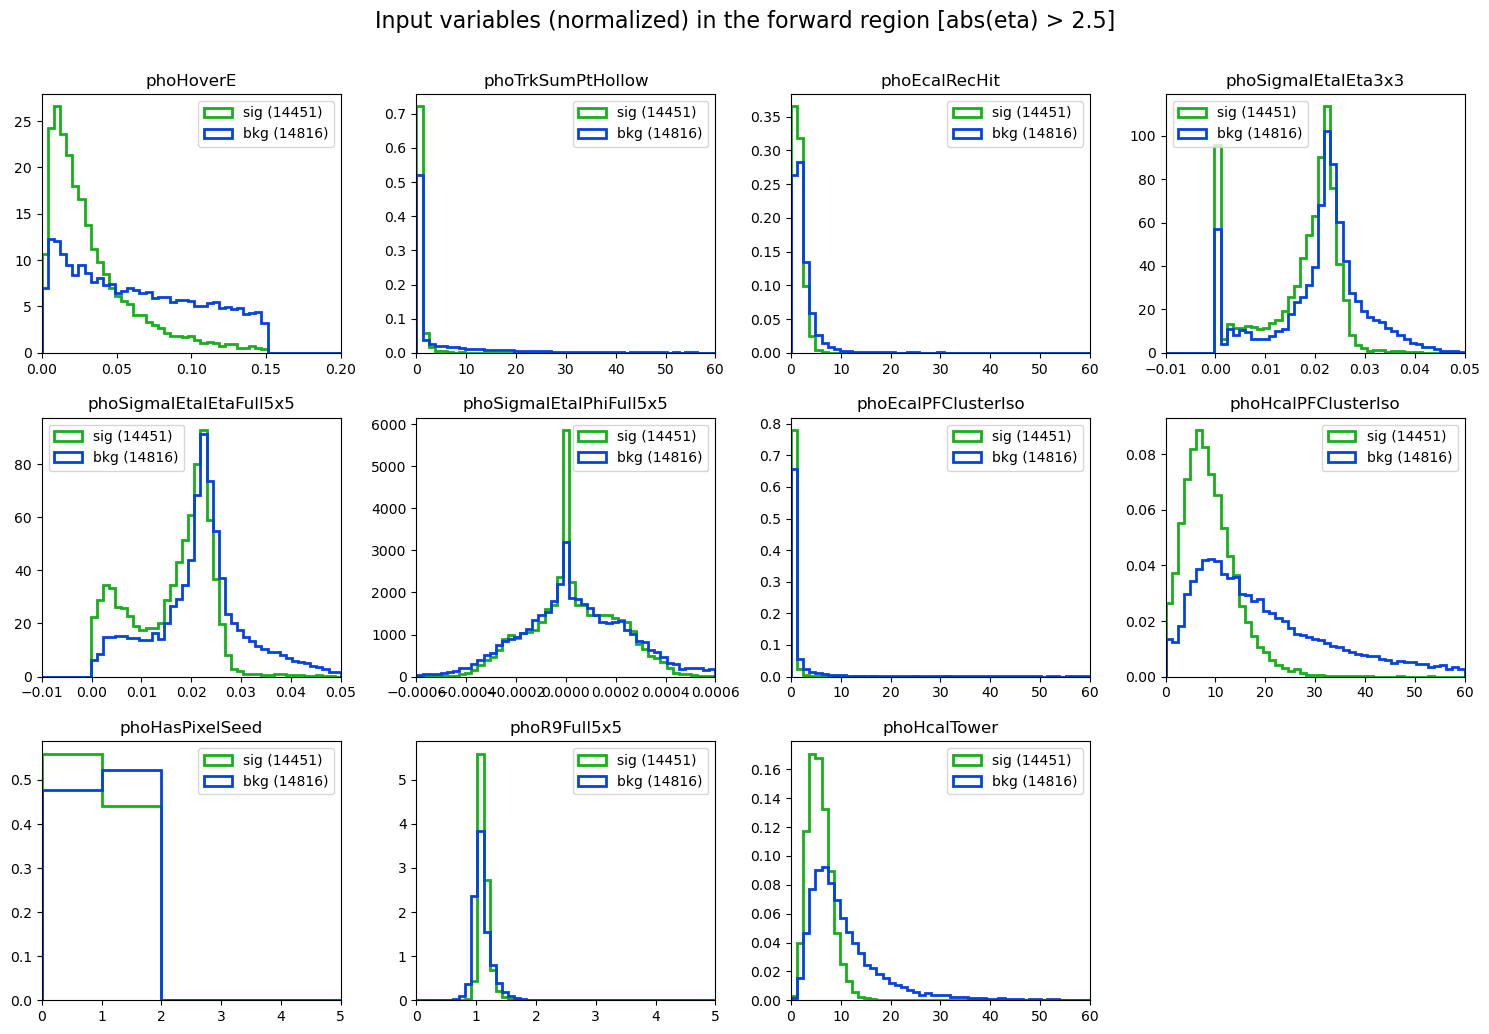

In [10]:
n_cols = 4
n_rows = (len(train_var) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3.5))
axs = axs.flatten()

for i, (col, _, _, xmin, xmax) in enumerate(train_var):
    ax = axs[i]
    
    #Automatically adjusting bins and x-range:
    sig_data = data[data['truth']==1][col].dropna()
    bkg_data = data[data['truth']==0][col].dropna()
    #min_val = min(sig_data.min(), bkg_data.min())
    #max_val = max(sig_data.max(), bkg_data.max())
    #nbins = np.histogram_bin_edges(np.concatenate((sig_data, bkg_data)), bins='auto').size - 1
    nbins = 50
    mybins = np.linspace(xmin, xmax, nbins)
    
    #Decorations:
    sig_label = f'sig ({len(sig_data)})'
    bkg_label = f'bkg ({len(bkg_data)})'
    sig_color = 'xkcd:green'
    bkg_color = 'xkcd:blue'
    common_hist_props = {
    'histtype': 'step',
    'density': True,
    'linewidth': 2,
    }
    
    #Exceptions:
    if col == 'phoHasPixelSeed' : mybins = np.arange(xmin, xmax + 1, 1)

    ax.hist(sig_data, bins=mybins, label=sig_label, color=sig_color, **common_hist_props)
    ax.hist(bkg_data, bins=mybins, label=bkg_label, color=bkg_color, **common_hist_props)
    ax.set_xlim(xmin, xmax)
    ax.set_title(f'{col}')
    ax.legend(loc='best')

# Remove any unused subplots
for i in range(len(train_var), len(axs)):
    fig.delaxes(axs[i])
    
fig.suptitle(f'Input variables (normalized) in the {plotinfo}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.25) #do this after tight layout

plt.savefig(f'plots/{figtype}_input_variables.png', dpi=300)
plt.show()

### Preparing normalized X (input parameters) and truth (target) arrays

In [11]:
train_cols = [entry[0] for entry in train_var]
print('The input variables are fed into the neural-network in the following order.')
for i, var in enumerate(train_cols) : print(i, var)

X, y = data[train_cols].values, data[['truth']].values

# Extract min and max values into NumPy arrays
min_values = np.array([entry[1] for entry in train_var])
max_values = np.array([entry[2] for entry in train_var])

def min_max_scaler(X, min_values, max_values):
    MaxMinusMin = max_values - min_values
    normedX = 2 * ((X - min_values) / MaxMinusMin) - 1.0
    return normedX

X = min_max_scaler(X, min_values, max_values)

print('Shapes of the input parameters X and y :')
print(X.shape, y.shape)

The input variables are fed into the neural-network in the following order.
0 phoHoverE
1 phoTrkSumPtHollow
2 phoEcalRecHit
3 phoSigmaIEtaIEta3x3
4 phoSigmaIEtaIEtaFull5x5
5 phoSigmaIEtaIPhiFull5x5
6 phoEcalPFClusterIso
7 phoHcalPFClusterIso
8 phoHasPixelSeed
9 phoR9Full5x5
10 phoHcalTower
Shapes of the input parameters X and y :
(29267, 11) (29267, 1)


### Evaulating the model and looking at the cut-based ID

In [12]:
def get_score_and_roc(model, X, y):
    #Predict using the existing model:
    y_truth = y
    y_predicted = model.predict(X)
    
    fpr, tpr, wps = roc_curve(y_truth, y_predicted) 
    auc_score = auc(tpr,1-fpr)    
    tpr=tpr*100      #True positve rate = How many signal passes the threshold - Signal Efficiency
    fnr=(1-fpr)*100  #False negative rate = How many background fails the threshold - Background Rejection
    
    return y_predicted, fnr, tpr, wps, auc_score

nnscore, fnr, tpr, wps, auc_score = get_score_and_roc(model, X, y)
print('The model is evulated, and TPR, FNR are calculated.')

data["NNScore"] = nnscore
print('The dataframe is updated with the NNscore.')

915/915 [==============================] - 3s 4ms/step
The model is evulated, and TPR, FNR are calculated.
The dataframe is updated with the NNscore.


In [13]:
data[['phoPt','phoEta','phoPhi','phoMatchingGenPt','isPromptFinalState','isPFPhoton','sample','truth','NNScore']]

,phoPt,phoEta,phoPhi,phoMatchingGenPt,isPromptFinalState,isPFPhoton,sample,truth,NNScore
0,126.783623,2.887835,-1.688151,22.221260,0,0,TauGun_E-100to3000,0,0.028086
1,10.010789,-2.570580,-1.401565,-999.000000,-999,0,QCD_PT-120to170,0,0.214682
2,22.498665,-2.635644,0.014132,22.060980,1,0,GJet_PT-10to40,1,0.060780
3,47.794384,-2.553571,1.280435,15.689229,0,0,QCD_PT-170to300,0,0.001691
4,28.108253,2.510065,-2.738763,-999.000000,-999,0,QCD_PT-300toInf,0,0.016540
...,...,...,...,...,...,...,...,...,...
29262,33.078903,2.628636,-0.687757,23.139143,0,0,QCD_PT-80to120,0,0.511381
29263,117.129196,2.557439,-0.746709,117.002052,1,0,GJet_PT-40,1,0.977914
29264,41.141788,-2.765661,-2.093461,42.411587,1,1,GJet_PT-40,1,0.794321
29265,71.424774,-2.778251,-0.425585,68.938080,1,0,GJet_PT-40,1,0.598346


In [14]:
print('Scanning tpr and fnr and different working points:')
print('wp'.ljust(10), 'tpr (%)'.ljust(10), 'fnr (%)')
interval = 100
for i in range(-interval, len(wps), interval):
    if i<0 : continue
    print(f'{wps[i]:.3f}'.ljust(10) + f'{tpr[i]:.2f}'.ljust(10) + f'{fnr[i]:.2f}')

Scanning tpr and fnr and different working points:
wp         tpr (%)    fnr (%)
inf       0.00      100.00
0.973     3.77      99.66
0.963     9.03      99.27
0.950     13.02     98.91
0.937     15.66     98.53
0.926     17.80     98.10
0.915     19.71     97.66
0.904     21.42     97.19
0.896     22.72     96.70
0.886     24.02     96.24
0.878     25.18     95.75
0.869     26.53     95.28
0.861     27.71     94.78
0.853     28.88     94.34
0.844     29.91     93.87
0.837     30.95     93.41
0.832     31.67     92.93
0.824     32.56     92.41
0.815     33.61     91.88
0.807     34.54     91.37
0.799     35.41     90.80
0.790     36.40     90.31
0.783     37.30     89.77
0.775     38.14     89.23
0.766     38.96     88.62
0.760     39.75     88.16
0.752     40.52     87.56
0.743     41.51     87.05
0.736     42.29     86.40
0.728     43.18     85.89
0.720     43.98     85.27
0.713     44.70     84.64
0.706     45.37     84.16
0.697     46.27     83.65
0.690     47.08     83.12
0.683   

### Defining working points:

In [15]:
# The cut-based PF-ID :
print('Information on the cut-based ID :')
PF_bkgpass =len(data.query('(isPFPhoton == 1) & (truth == 0)'))
PF_bkgfail =len(data.query('(isPFPhoton == 0) & (truth == 0)'))
PF_sigpass =len(data.query('(isPFPhoton == 1) & (truth == 1)'))
PF_sigfail =len(data.query('(isPFPhoton == 0) & (truth == 1)'))
PF_bkgrej  =( PF_bkgfail/(PF_bkgpass+PF_bkgfail) )*100
PF_sigeff  =( PF_sigpass/(PF_sigpass+PF_sigfail) )*100
print(f'Signal efficiency and background rejection of the cut-based ID : {PF_sigeff:.2f} % and {PF_bkgrej:.2f}%')

Information on the cut-based ID :
Signal efficiency and background rejection of the cut-based ID : 63.00 % and 75.34%


In [16]:
#EGamma working point
if 'barrel' in model_to_use: example_wp = 0.22
elif 'endcap' in model_to_use: example_wp = 0.42

nn_bkgpass =len(data.query(f'(NNScore > {example_wp}) & (truth == 0)'))
nn_bkgfail =len(data.query(f'(NNScore < {example_wp}) & (truth == 0)'))
nn_sigpass =len(data.query(f'(NNScore > {example_wp}) & (truth == 1)'))
nn_sigfail =len(data.query(f'(NNScore < {example_wp}) & (truth == 1)'))
nn_bkgrej  =( nn_bkgfail/(nn_bkgpass+nn_bkgfail) )*100
nn_sigeff  =( nn_sigpass/(nn_sigpass+nn_sigfail) )*100
print(f'Signal efficiency and background rejection of the working point: {nn_sigeff:.2f} % and {nn_bkgrej:.2f}%')

Signal efficiency and background rejection of the working point: 69.03 % and 62.56%


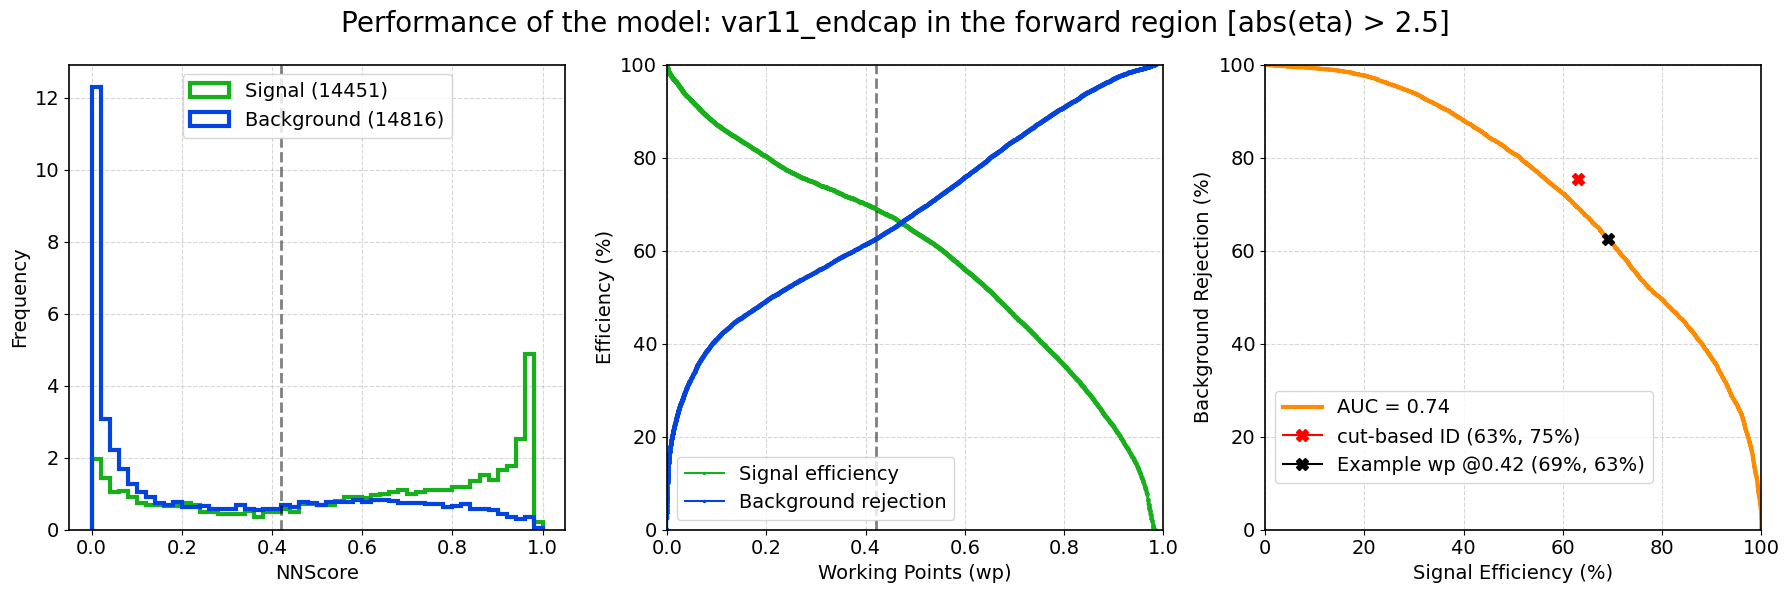

Done!


In [17]:
# Define custom binning for the NNScore
mybins = np.arange(0, 1.02, 0.02)

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#Common ax decorations:
for ax in axs:
    ax.spines['top'].set_linewidth(1.2)    # Top boundary
    ax.spines['right'].set_linewidth(1.2)  # Right boundary
    ax.spines['bottom'].set_linewidth(1.2) # Bottom boundary
    ax.spines['left'].set_linewidth(1.2)   # Left boundary
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.5, linestyle='--')

# Define common histogram properties
hist_props = {
    'histtype': 'step',
    'density': True,
    'linewidth': 3,
}
nsig = len(data[data['truth']==1])
nbkg = len(data[data['truth']==0])
# Left subplot: NNScore distribution
axs[0].hist(data[data['truth']==1]['NNScore'], bins=mybins, color='xkcd:green', label=f'Signal ({nsig})', **hist_props)
axs[0].hist(data[data['truth']==0]['NNScore'], bins=mybins, color='xkcd:blue', label=f'Background ({nbkg})', **hist_props)
axs[0].axvline(x=example_wp, color='xkcd:black', linestyle='--', linewidth=2, alpha=0.5)
axs[0].set_xlabel('NNScore', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].legend(loc='upper center', fontsize=14)
#axs[0].set_title('Signal and background separation', fontsize=18)

axs[1].plot(wps, tpr, label='Signal efficiency',    marker='o', markersize=1.5, color='xkcd:green')
axs[1].plot(wps, fnr, label='Background rejection', marker='o', markersize=1.5, color='xkcd:blue')    
axs[1].axvline(x=example_wp, color='xkcd:black', linestyle='--', linewidth=2, alpha=0.5)
axs[1].set_xlabel('Working Points (wp)', fontsize=14)
axs[1].set_ylabel('Efficiency (%)', fontsize=14)
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 100])
axs[1].legend(loc='best', fontsize=14)
#axs[1].set_title('Scanning thorugh working points', fontsize=18)

# ROC
axs[2].plot(tpr, fnr, color='darkorange', lw=3, label=f'AUC = {auc_score:.2f}')
#axs[2].plot([0, 100], [100, 0], color='navy', lw=2, linestyle='--', alpha=0.2)
axs[2].plot(PF_sigeff, PF_bkgrej, marker='X', color="red",  markersize=8, label=f'cut-based ID ({PF_sigeff:.0f}%, {PF_bkgrej:.0f}%)')
axs[2].plot(nn_sigeff, nn_bkgrej, marker='X', color="xkcd:black", markersize=8, label=f'Example wp @{example_wp} ({nn_sigeff:.0f}%, {nn_bkgrej:.0f}%)')
axs[2].set_xlim([0, 100])
axs[2].set_ylim([0, 100])
axs[2].set_xlabel('Signal Efficiency (%)', fontsize=14)
axs[2].set_ylabel('Background Rejection (%)', fontsize=14)
axs[2].legend(loc='center left', fontsize=14, bbox_to_anchor=(0.0, 0.20))
#axs[2].set_title('ROC curve', fontsize=18)

# Adjust layout
fig.suptitle(f'Performance of the model: {model_to_use} in the {plotinfo}', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0.30) #do this after tight layout

# Display the plot after saving.
plt.savefig(f'plots/{figtype}_performance.png', dpi=300)
plt.show()

print('Done!')